# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 2, #degree
        'n': 9, #number of variables
        'monomial_vars': None, #int or None
        'laurent': True, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0.15,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': None, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 20, #Float for fraction, Int for number 0
        
        'normalize_inet_data': True,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'symbolic_regression_evaluation': False,
        'per_network_evaluation': False,        
    },
    'computation':{
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 19683
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 2], [0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 2, 1], [0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 2], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 2], [0, 0, 0, 0, 0, 0, 1, 2, 0], [0, 0, 0, 0, 0, 0, 1, 2, 1], [0, 0, 0, 0, 0, 0, 1, 2, 2], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 1], [0, 0, 0, 0, 0, 0, 2, 0, 2], [0, 0, 0, 0, 0, 0, 2, 1, 0], [0, 0, 0, 0, 0, 0, 2, 1, 1], [0, 0, 0, 0, 0, 0, 2, 1, 2], [0, 0, 0, 0, 0, 0, 2, 2, 0], [0, 0, 0, 0, 0, 0, 2, 2, 1], [0, 0, 0, 0, 0, 0, 2, 2, 2], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0, 2], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, 1, 0, 1, 2], [0, 0, 0, 0, 0, 1, 0, 2

  0%|          | 0/19683 [00:00<?, ?it/s]

List length: 55
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0

In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_55_drop0.25e500b256_custom/lnets_50000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0.15bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_50000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0.15bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data
        
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net')['path_identifier_interpretation_net_data']
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=20)]: Using backend MultiprocessingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 out of   1 | elapsed:  8.2min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
33553  1373158606            -0.278            -0.667            -0.234   
9427   1373158606            -0.131             0.830            -0.700   
199    1373158606             0.360            -0.884             0.858   
12447  1373158606             0.088            -0.031            -0.050   
39489  1373158606            -0.554            -0.054            -0.761   

       000000010-target  000000011-target  000000020-target  000000100-target  \
33553            -0.161            -0.706             0.321            -0.960   
9427             -0.436            -0.003            -0.641             0.294   
199              -0.555             0.999            -0.657             0.543   
12447             0.522             0.888             0.295            -0.280   
39489            -0.447            -0.387             0.157             0.654   

       000000101-target  000000110-target  000000200-target  000001000-target  \
33553            -0.786            -0.789            -0.921            -0.466   
9427              0.403             0.083             0.710             0.852   
199              -0.553            -0.838             0.750             0.718   
12447            -0.620            -0.300             0.503             0.331   
39489            -0.644            -0.461            -0.230             0.321   

       000001001-target  000001010-target  000001100-target  000002000-target  \
33553             0.352             0.617            -0.600             0.188   
9427              0.654             0.580             0.576            -0.798   
199              -0.193             0.405             0.114             0.706   
12447             0.966             0.092             0.814            -0.631   
39489            -0.420             0.849            -0.870             0.717   

       000010000-target  000010001-target  000010010-target  000010100-target  \
33553            -0.186             0.003             0.787             0.512   
9427              0.431            -0.042            -0.664             0.823   
199              -0.370             0.047            -0.029            -0.292   
12447            -0.748            -0.376             0.412             0.489   
39489            -0.535             0.101             0.045            -0.776   

       000011000-target  000020000-target  000100000-target  000100001-target  \
33553             0.125            -0.271            -0.022             0.009   
9427             -0.509             0.561             0.794             0.064   
199               0.783            -0.668            -0.701             0.154   
12447            -0.218             0.363            -0.265             0.302   
39489             0.610             0.906            -0.538             0.135   

       000100010-target  000100100-target  000101000-target  000110000-target  \
33553            -0.102             0.896            -0.015             0.586   
9427              0.117             0.333             0.161            -0.337   
199               0.315            -0.611            -0.219             0.893   
12447            -0.662             0.732             0.486            -0.797   
39489            -0.625            -0.707             0.256            -0.123   

       000200000-target  001000000-target  001000001-target  001000010-target  \
33553             0.246            -0.532             0.500             0.028   
9427             -0.032            -0.438             0.936             0.499   
199              -0.507             0.337             0.480            -0.104   
12447             0.512            -0.421             0.605            -0.775   
39489             0.346             0.688            -0.276             0.955   

       001000100-target  001001000-target  001010000-target  001100000-target  \
33553            -0.403             0.341             0.372             

In [12]:
lambda_net_dataset.as_pandas().describe()

seed  000000000-target  000000001-target  000000002-target  \
count      50000.000         50000.000         50000.000         50000.000   
mean  1373158606.000            -0.002             0.002             0.005   
std            0.000             0.577             0.577             0.578   
min   1373158606.000            -1.000            -1.000            -1.000   
25%   1373158606.000            -0.501            -0.497            -0.494   
50%   1373158606.000            -0.004             0.007             0.008   
75%   1373158606.000             0.497             0.500             0.507   
max   1373158606.000             1.000             1.000             1.000   

       000000010-target  000000011-target  000000020-target  000000100-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean             -0.002            -0.001            -0.002             0.001   
std               0.576             0.577             0.579             0.578   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.498            -0.501            -0.505            -0.501   
50%              -0.005            -0.002            -0.000             0.000   
75%               0.496             0.500             0.502             0.504   
max               1.000             1.000             1.000             1.000   

       000000101-target  000000110-target  000000200-target  000001000-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean              0.004             0.002            -0.002            -0.002   
std               0.577             0.577             0.576             0.577   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.497            -0.496            -0.501            -0.496   
50%               0.007             0.004            -0.005            -0.004   
75%               0.503             0.500             0.496             0.498   
max               1.000             1.000             1.000             1.000   

       000001001-target  000001010-target  000001100-target  000002000-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean             -0.001            -0.002             0.002             0.001   
std               0.577             0.577             0.575             0.577   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.496            -0.500            -0.494            -0.499   
50%              -0.003            -0.003             0.000             0.002   
75%               0.500             0.497             0.499             0.498   
max               1.000             1.000             1.000             1.000   

       000010000-target  000010001-target  000010010-target  000010100-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean             -0.003            -0.005            -0.003            -0.003   
std               0.579             0.577             0.576             0.578   
min              -1.000            -1.000            -1.000            -1.000   
25%              -0.501            -0.508            -0.503            -0.507   
50%              -0.006            -0.007            -0.003            -0.009   
75%               0.499             0.497             0.494             0.498   
max               1.000             1.000             1.000             1.000   

       000011000-target  000020000-target  000100000-target  000100001-target  \
count         50000.000         50000.000         50000.000         50000.000   
mean              0.003            -0.003            -0.002            -0.001   
std               0.577             0.579             0.577             0.577   
min              -1.000            -1.000            -1.000          

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.73082941, 0.05213017, 0.66572068, 0.87712713, 0.06067624,
        0.09081775, 0.72254459, 0.20717409, 0.4915632 ],
       [0.624057  , 0.90447014, 0.92468088, 0.93750586, 0.65198702,
        0.44290109, 0.35719106, 0.71362528, 0.38521999],
       [0.20728853, 0.3990572 , 0.23764756, 0.50852175, 0.94043697,
        0.8591    , 0.34855253, 0.87088499, 0.99980287],
       [0.58654567, 0.8845656 , 0.90932963, 0.90834534, 0.62394553,
        0.8081525 , 0.91104895, 0.75970973, 0.96291015],
       [0.8217497 , 0.33359407, 0.6376189 , 0.62417853, 0.67121809,
        0.66421107, 0.52845012, 0.51743737, 0.97099857],
       [0.60145068, 0.17803421, 0.38437711, 0.67995954, 0.98294559,
        0.52212317, 0.62965456, 0.13924224, 0.75433468],
       [0.7222318 , 0.81118147, 0.21146383, 0.56395218, 0.82417586,
        0.83460542, 0.3015649 , 0.88933477, 0.25549277],
       [0.73541227, 0.09589284, 0.53089947, 0.84096981, 0.90104095,
        0.86411768, 0.26617861, 0.48882316, 0.82097931],


In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-1.13771771],
       [ 0.47982393],
       [-0.42441769],
       [-0.91328845],
       [ 0.04898086],
       [-0.48349864],
       [ 1.47318748],
       [ 1.01904184],
       [ 0.77653566],
       [-0.80453525]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        
        if inet_training_without_noise:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
        else:
            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
    else:
        
        if inet_training_without_noise:
            lambda_net_train_dataset = lambda_net_dataset_list_without_noise
            
            lambda_net_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            
            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        else:        
            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44982, 3192)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4998, 3192)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(20, 3192)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
44620  1373158606             0.840            -0.623            -0.094   
17634  1373158606             0.948             0.332             0.591   
25166  1373158606            -0.077             0.410             0.354   
38480  1373158606             0.792            -0.680             0.383   
6059   1373158606             0.839            -0.954            -0.152   

       000000010-target  000000011-target  000000020-target  000000100-target  \
44620            -0.125            -0.470            -0.095            -0.747   
17634             0.004             0.662             0.377             0.688   
25166            -0.248            -0.376             0.813            -0.220   
38480            -0.596            -0.768             0.119             0.790   
6059              0.666             0.207             0.220            -0.340   

       000000101-target  000000110-target  000000200-target  000001000-target  \
44620            -0.563             0.656             0.023            -0.387   
17634            -0.790            -0.836            -0.952             0.477   
25166            -0.525             0.109            -0.973            -0.831   
38480             0.896            -0.073            -0.220            -0.093   
6059              0.409            -0.766             0.268            -0.491   

       000001001-target  000001010-target  000001100-target  000002000-target  \
44620            -0.249             0.412             0.823            -0.920   
17634             0.012             0.003             0.406            -0.833   
25166            -0.686             0.275            -0.256            -0.107   
38480             0.140             0.876            -0.391            -0.506   
6059             -0.765             0.289             0.516            -0.889   

       000010000-target  000010001-target  000010010-target  000010100-target  \
44620             0.887            -0.300             0.816            -0.266   
17634            -0.123            -0.128             0.437             0.838   
25166            -0.873            -0.256            -0.958             0.095   
38480            -0.288             0.454            -0.252             0.420   
6059              0.851             0.824            -0.402            -0.974   

       000011000-target  000020000-target  000100000-target  000100001-target  \
44620             0.506            -0.848             0.637             0.138   
17634             0.164             0.211            -0.099             0.934   
25166             0.228             0.182            -0.088            -0.705   
38480             0.757            -0.562             0.468             0.043   
6059             -0.507             0.619            -0.409            -0.502   

       000100010-target  000100100-target  000101000-target  000110000-target  \
44620            -0.867            -0.157            -0.888             0.570   
17634            -0.012             0.319            -0.834             0.571   
25166             0.408            -0.000             0.960             0.763   
38480            -0.981             0.123            -0.390             0.908   
6059             -0.436            -0.986            -0.205            -0.553   

       000200000-target  001000000-target  001000001-target  001000010-target  \
44620             0.412             0.068            -0.613            -0.004   
17634            -0.832             0.026            -0.343             0.316   
25166             0.754            -0.313             0.189             0.652   
38480             0.682             0.911             0.414             0.795   
6059             -0.002            -0.470            -0.374             0.465   

       001000100-target  001001000-target  001010000-target  001100000-target  \
44620            -0.609            -0.921             0.263             

In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
38643  1373158606             0.113            -0.442            -0.438   
31220  1373158606             0.988             0.975            -0.706   
36358  1373158606            -0.794            -0.298             0.880   
22285  1373158606             0.601             0.853             0.787   
34200  1373158606            -0.778            -0.336             0.403   

       000000010-target  000000011-target  000000020-target  000000100-target  \
38643             0.813            -0.305             0.129            -0.296   
31220             0.460            -0.974            -0.703            -0.739   
36358            -0.039             0.843             0.098             0.389   
22285             0.502             0.245            -0.134            -0.220   
34200            -0.894            -0.497             0.032            -0.512   

       000000101-target  000000110-target  000000200-target  000001000-target  \
38643            -0.107            -0.176            -0.904            -0.056   
31220            -0.869             0.125            -0.142            -0.316   
36358             0.413             0.391            -0.632             0.386   
22285            -0.699             0.212            -0.564             0.334   
34200             0.993             0.096            -0.724             0.911   

       000001001-target  000001010-target  000001100-target  000002000-target  \
38643             0.187            -0.817            -0.425             0.980   
31220            -0.235             0.225            -0.894            -0.516   
36358             0.153            -0.263            -0.030            -0.098   
22285            -0.011             0.585             0.299             0.101   
34200            -0.019             0.064             0.716             0.934   

       000010000-target  000010001-target  000010010-target  000010100-target  \
38643            -0.490            -0.487             0.443            -0.158   
31220            -0.663             0.240             0.389            -0.505   
36358            -0.004            -0.572            -0.829             0.214   
22285             0.573             0.598            -0.115             0.824   
34200            -0.431             0.152            -0.021             0.658   

       000011000-target  000020000-target  000100000-target  000100001-target  \
38643             0.309            -0.314            -0.945             0.636   
31220            -0.076             0.271             0.684             0.966   
36358            -0.676             0.626             0.828             0.046   
22285             0.819             0.149            -0.342            -0.586   
34200            -0.221             0.489            -0.532             0.908   

       000100010-target  000100100-target  000101000-target  000110000-target  \
38643            -0.473            -0.637             0.805             0.827   
31220             0.691            -0.069             0.444            -0.731   
36358             0.772             0.257             0.414            -0.665   
22285             0.665             0.636            -0.187            -0.038   
34200            -0.162            -0.207             0.680             0.057   

       000200000-target  001000000-target  001000001-target  001000010-target  \
38643            -0.412            -0.047             0.577            -0.762   
31220             0.837             0.883             0.868             0.210   
36358             0.208             0.358             0.703             0.687   
22285            -0.259             0.287             0.490            -0.889   
34200             0.161            -0.247            -0.755            -0.810   

       001000100-target  001001000-target  001010000-target  001100000-target  \
38643            -0.006             0.890            -0.539             

In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
35587  1373158606            -0.504            -0.292             0.595   
32681  1373158606            -0.152             0.146             0.135   
40971  1373158606             0.130             0.854            -0.511   
21022  1373158606            -0.454             0.004             0.378   
6403   1373158606             0.532             0.794            -0.808   

       000000010-target  000000011-target  000000020-target  000000100-target  \
35587            -0.354            -0.615             0.236            -0.489   
32681            -0.284             0.913             0.750             0.365   
40971             0.702            -0.262            -0.207             0.213   
21022            -0.284             0.541             0.492             0.568   
6403             -0.471            -0.281             0.428             0.260   

       000000101-target  000000110-target  000000200-target  000001000-target  \
35587            -0.443            -0.373             0.040            -0.455   
32681            -0.678            -0.271             0.064             0.579   
40971            -0.955            -0.358             0.576             0.086   
21022            -0.288            -0.540             0.313            -0.528   
6403              0.729             0.748             0.407             0.895   

       000001001-target  000001010-target  000001100-target  000002000-target  \
35587            -0.676             0.048            -0.455             0.891   
32681            -0.035             0.701            -0.129            -0.309   
40971            -0.295            -0.490            -0.395            -0.322   
21022             0.877             0.115             0.107             0.776   
6403             -0.392            -0.279            -0.716             0.575   

       000010000-target  000010001-target  000010010-target  000010100-target  \
35587             0.812            -0.986            -0.613            -0.024   
32681             0.102             0.371             0.165            -0.347   
40971            -0.136             0.119            -0.220             0.341   
21022            -0.289            -0.044             0.933            -0.870   
6403              0.189            -0.598             0.756            -0.819   

       000011000-target  000020000-target  000100000-target  000100001-target  \
35587            -0.980            -0.547            -0.009            -0.945   
32681            -0.775            -0.557             0.562             0.613   
40971             0.882             0.322             0.406            -0.663   
21022            -0.121             0.308             0.557            -0.658   
6403             -0.029             0.102            -0.199            -0.801   

       000100010-target  000100100-target  000101000-target  000110000-target  \
35587             0.772             0.353            -0.211             0.632   
32681             0.896            -0.199             0.735             0.564   
40971             0.136            -0.180             0.128            -0.792   
21022            -0.873            -0.998             0.731             0.783   
6403              0.382            -0.551             0.488             0.983   

       000200000-target  001000000-target  001000001-target  001000010-target  \
35587            -0.792            -0.966            -0.573             0.721   
32681            -0.223             0.133             0.137             0.711   
40971            -0.683             0.782             0.773            -0.284   
21022            -0.059            -0.675             0.725            -0.461   
6403             -0.088             0.714            -0.333             0.281   

       001000100-target  001001000-target  001010000-target  001100000-target  \
35587            -0.650            -0.517             0.912            -

## Interpretation Network Training

In [22]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   11.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   15.9s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   23.3s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   32.2s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:   44.1s
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:   58.0s
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed:  2.4min
[Parallel(n_jobs=20)]: Done 6010 tasks      | elapsed:  2.9min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed:  3.4min
[Parallel(n_jobs=20)]: Done 8410 tasks      | elapsed:  3.9min
[Parallel(n_jobs=20)]: Done 9760 tasks      | elapsed:  4.5min
[Parallel(n_jobs=20)]: Done 11210 tasks      

Epoch 1/500
176/176 [==============================] - 86s 457ms/step - loss: 0.2014 - r2_inet_coefficient_loss: 0.0091 - r2_inet_lambda_fv_loss: 1.0763 - mae_inet_coefficient_loss: 0.4891 - mae_inet_lambda_fv_loss: 0.2014 - val_loss: 0.1137 - val_r2_inet_coefficient_loss: -0.0044 - val_r2_inet_lambda_fv_loss: -0.3708 - val_mae_inet_coefficient_loss: 0.4855 - val_mae_inet_lambda_fv_loss: 0.1138
Epoch 2/500
176/176 [==============================] - 74s 423ms/step - loss: 0.1095 - r2_inet_coefficient_loss: -0.0096 - r2_inet_lambda_fv_loss: -0.4006 - mae_inet_coefficient_loss: 0.4838 - mae_inet_lambda_fv_loss: 0.1095 - val_loss: 0.0756 - val_r2_inet_coefficient_loss: -0.0307 - val_r2_inet_lambda_fv_loss: -0.7114 - val_mae_inet_coefficient_loss: 0.4788 - val_mae_inet_lambda_fv_loss: 0.0756
Epoch 3/500
176/176 [==============================] - 74s 423ms/step - loss: 0.0826 - r2_inet_coefficient_loss: -0.0285 - r2_inet_lambda_fv_loss: -0.6531 - mae_inet_coefficient_loss: 0.4791 - mae_inet_

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 98s 555ms/step - loss: 0.0508 - r2_inet_coefficient_loss: -0.0758 - r2_inet_lambda_fv_loss: -0.8671 - mae_inet_coefficient_loss: 0.4672 - mae_inet_lambda_fv_loss: 0.0508 - val_loss: 0.0452 - val_r2_inet_coefficient_loss: -0.0801 - val_r2_inet_lambda_fv_loss: -0.8937 - val_mae_inet_coefficient_loss: 0.4661 - val_mae_inet_lambda_fv_loss: 0.0452
Epoch 31/500
176/176 [==============================] - 98s 554ms/step - loss: 0.0506 - r2_inet_coefficient_loss: -0.0781 - r2_inet_lambda_fv_loss: -0.8681 - mae_inet_coefficient_loss: 0.4664 - mae_inet_lambda_fv_loss: 0.0506 - val_loss: 0.0472 - val_r2_inet_coefficient_loss: -0.0829 - val_r2_inet_lambda_fv_loss: -0.8856 - val_mae_inet_coefficient_loss: 0.4654 - val_mae_inet_lambda_fv_loss: 0.0472
Epoch 32/500
176/176 [==============================] - 98s 557ms/step - loss: 0.0501 - r2_inet_coefficient_loss: -0.0804 - r2_inet_lambda_fv_loss: -0.8707 - mae_inet_coefficient_loss: 0.4658 - mae_inet_lambda_f

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 98s 555ms/step - loss: 0.0424 - r2_inet_coefficient_loss: -0.1458 - r2_inet_lambda_fv_loss: -0.9080 - mae_inet_coefficient_loss: 0.4482 - mae_inet_lambda_fv_loss: 0.0424 - val_loss: 0.0360 - val_r2_inet_coefficient_loss: -0.1515 - val_r2_inet_lambda_fv_loss: -0.9333 - val_mae_inet_coefficient_loss: 0.4471 - val_mae_inet_lambda_fv_loss: 0.0360
Epoch 60/500
176/176 [==============================] - 98s 556ms/step - loss: 0.0421 - r2_inet_coefficient_loss: -0.1475 - r2_inet_lambda_fv_loss: -0.9094 - mae_inet_coefficient_loss: 0.4475 - mae_inet_lambda_fv_loss: 0.0421 - val_loss: 0.0359 - val_r2_inet_coefficient_loss: -0.1530 - val_r2_inet_lambda_fv_loss: -0.9338 - val_mae_inet_coefficient_loss: 0.4466 - val_mae_inet_lambda_fv_loss: 0.0359
Epoch 61/500
176/176 [==============================] - 97s 553ms/step - loss: 0.0418 - r2_inet_coefficient_loss: -0.1489 - r2_inet_lambda_fv_loss: -0.9107 - mae_inet_coefficient_loss: 0.4476 - mae_inet_lambda_f

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 98s 556ms/step - loss: 0.0385 - r2_inet_coefficient_loss: -0.1775 - r2_inet_lambda_fv_loss: -0.9241 - mae_inet_coefficient_loss: 0.4394 - mae_inet_lambda_fv_loss: 0.0385 - val_loss: 0.0325 - val_r2_inet_coefficient_loss: -0.1820 - val_r2_inet_lambda_fv_loss: -0.9460 - val_mae_inet_coefficient_loss: 0.4387 - val_mae_inet_lambda_fv_loss: 0.0325
Epoch 90/500
176/176 [==============================] - 98s 557ms/step - loss: 0.0384 - r2_inet_coefficient_loss: -0.1783 - r2_inet_lambda_fv_loss: -0.9244 - mae_inet_coefficient_loss: 0.4395 - mae_inet_lambda_fv_loss: 0.0384 - val_loss: 0.0331 - val_r2_inet_coefficient_loss: -0.1828 - val_r2_inet_lambda_fv_loss: -0.9443 - val_mae_inet_coefficient_loss: 0.4385 - val_mae_inet_lambda_fv_loss: 0.0331
Epoch 91/500
176/176 [==============================] - 98s 558ms/step - loss: 0.0384 - r2_inet_coefficient_loss: -0.1788 - r2_inet_lambda_fv_loss: -0.9244 - mae_inet_coefficient_loss: 0.4392 - mae_inet_lambda_f

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 98s 556ms/step - loss: 0.0368 - r2_inet_coefficient_loss: -0.1908 - r2_inet_lambda_fv_loss: -0.9308 - mae_inet_coefficient_loss: 0.4356 - mae_inet_lambda_fv_loss: 0.0368 - val_loss: 0.0314 - val_r2_inet_coefficient_loss: -0.1941 - val_r2_inet_lambda_fv_loss: -0.9500 - val_mae_inet_coefficient_loss: 0.4353 - val_mae_inet_lambda_fv_loss: 0.0314
Epoch 119/500
176/176 [==============================] - 98s 556ms/step - loss: 0.0367 - r2_inet_coefficient_loss: -0.1912 - r2_inet_lambda_fv_loss: -0.9310 - mae_inet_coefficient_loss: 0.4355 - mae_inet_lambda_fv_loss: 0.0367 - val_loss: 0.0298 - val_r2_inet_coefficient_loss: -0.1943 - val_r2_inet_lambda_fv_loss: -0.9545 - val_mae_inet_coefficient_loss: 0.4352 - val_mae_inet_lambda_fv_loss: 0.0298
Epoch 120/500
176/176 [==============================] - 98s 556ms/step - loss: 0.0367 - r2_inet_coefficient_loss: -0.1911 - r2_inet_lambda_fv_loss: -0.9312 - mae_inet_coefficient_loss: 0.4356 - mae_inet_lambda

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 97s 554ms/step - loss: 0.0355 - r2_inet_coefficient_loss: -0.1973 - r2_inet_lambda_fv_loss: -0.9354 - mae_inet_coefficient_loss: 0.4339 - mae_inet_lambda_fv_loss: 0.0355 - val_loss: 0.0315 - val_r2_inet_coefficient_loss: -0.2003 - val_r2_inet_lambda_fv_loss: -0.9499 - val_mae_inet_coefficient_loss: 0.4336 - val_mae_inet_lambda_fv_loss: 0.0315
Epoch 146/500
176/176 [==============================] - 98s 557ms/step - loss: 0.0355 - r2_inet_coefficient_loss: -0.1976 - r2_inet_lambda_fv_loss: -0.9353 - mae_inet_coefficient_loss: 0.4339 - mae_inet_lambda_fv_loss: 0.0355 - val_loss: 0.0306 - val_r2_inet_coefficient_loss: -0.2014 - val_r2_inet_lambda_fv_loss: -0.9524 - val_mae_inet_coefficient_loss: 0.4333 - val_mae_inet_lambda_fv_loss: 0.0306
Epoch 147/500
176/176 [==============================] - 98s 554ms/step - loss: 0.0355 - r2_inet_coefficient_loss: -0.1979 - r2_inet_lambda_fv_loss: -0.9356 - mae_inet_coefficient_loss: 0.4337 - mae_inet_lambda

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 97s 551ms/step - loss: 0.0346 - r2_inet_coefficient_loss: -0.2015 - r2_inet_lambda_fv_loss: -0.9388 - mae_inet_coefficient_loss: 0.4327 - mae_inet_lambda_fv_loss: 0.0346 - val_loss: 0.0300 - val_r2_inet_coefficient_loss: -0.2043 - val_r2_inet_lambda_fv_loss: -0.9543 - val_mae_inet_coefficient_loss: 0.4325 - val_mae_inet_lambda_fv_loss: 0.0300
Epoch 174/500
176/176 [==============================] - 97s 551ms/step - loss: 0.0345 - r2_inet_coefficient_loss: -0.2024 - r2_inet_lambda_fv_loss: -0.9389 - mae_inet_coefficient_loss: 0.4324 - mae_inet_lambda_fv_loss: 0.0345 - val_loss: 0.0291 - val_r2_inet_coefficient_loss: -0.2049 - val_r2_inet_lambda_fv_loss: -0.9570 - val_mae_inet_coefficient_loss: 0.4323 - val_mae_inet_lambda_fv_loss: 0.0290
Epoch 175/500
176/176 [==============================] - 97s 551ms/step - loss: 0.0344 - r2_inet_coefficient_loss: -0.2022 - r2_inet_lambda_fv_loss: -0.9391 - mae_inet_coefficient_loss: 0.4325 - mae_inet_lambda

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 97s 551ms/step - loss: 0.0339 - r2_inet_coefficient_loss: -0.2054 - r2_inet_lambda_fv_loss: -0.9413 - mae_inet_coefficient_loss: 0.4316 - mae_inet_lambda_fv_loss: 0.0339 - val_loss: 0.0299 - val_r2_inet_coefficient_loss: -0.2071 - val_r2_inet_lambda_fv_loss: -0.9548 - val_mae_inet_coefficient_loss: 0.4317 - val_mae_inet_lambda_fv_loss: 0.0298
Epoch 203/500
176/176 [==============================] - 97s 550ms/step - loss: 0.0338 - r2_inet_coefficient_loss: -0.2052 - r2_inet_lambda_fv_loss: -0.9416 - mae_inet_coefficient_loss: 0.4316 - mae_inet_lambda_fv_loss: 0.0338 - val_loss: 0.0291 - val_r2_inet_coefficient_loss: -0.2079 - val_r2_inet_lambda_fv_loss: -0.9570 - val_mae_inet_coefficient_loss: 0.4315 - val_mae_inet_lambda_fv_loss: 0.0291
Epoch 204/500
176/176 [==============================] - 97s 551ms/step - loss: 0.0337 - r2_inet_coefficient_loss: -0.2056 - r2_inet_lambda_fv_loss: -0.9418 - mae_inet_coefficient_loss: 0.4316 - mae_inet_lambda

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 97s 550ms/step - loss: 0.0333 - r2_inet_coefficient_loss: -0.2079 - r2_inet_lambda_fv_loss: -0.9430 - mae_inet_coefficient_loss: 0.4308 - mae_inet_lambda_fv_loss: 0.0333 - val_loss: 0.0298 - val_r2_inet_coefficient_loss: -0.2096 - val_r2_inet_lambda_fv_loss: -0.9551 - val_mae_inet_coefficient_loss: 0.4310 - val_mae_inet_lambda_fv_loss: 0.0298
Epoch 230/500
176/176 [==============================] - 97s 549ms/step - loss: 0.0331 - r2_inet_coefficient_loss: -0.2078 - r2_inet_lambda_fv_loss: -0.9437 - mae_inet_coefficient_loss: 0.4309 - mae_inet_lambda_fv_loss: 0.0331 - val_loss: 0.0287 - val_r2_inet_coefficient_loss: -0.2095 - val_r2_inet_lambda_fv_loss: -0.9581 - val_mae_inet_coefficient_loss: 0.4311 - val_mae_inet_lambda_fv_loss: 0.0287
Epoch 231/500
176/176 [==============================] - 97s 550ms/step - loss: 0.0331 - r2_inet_coefficient_loss: -0.2078 - r2_inet_lambda_fv_loss: -0.9438 - mae_inet_coefficient_loss: 0.4311 - mae_inet_lambda

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 97s 549ms/step - loss: 0.0327 - r2_inet_coefficient_loss: -0.2100 - r2_inet_lambda_fv_loss: -0.9452 - mae_inet_coefficient_loss: 0.4302 - mae_inet_lambda_fv_loss: 0.0327 - val_loss: 0.0298 - val_r2_inet_coefficient_loss: -0.2125 - val_r2_inet_lambda_fv_loss: -0.9553 - val_mae_inet_coefficient_loss: 0.4302 - val_mae_inet_lambda_fv_loss: 0.0298
Epoch 259/500
176/176 [==============================] - 97s 551ms/step - loss: 0.0327 - r2_inet_coefficient_loss: -0.2098 - r2_inet_lambda_fv_loss: -0.9452 - mae_inet_coefficient_loss: 0.4304 - mae_inet_lambda_fv_loss: 0.0327 - val_loss: 0.0295 - val_r2_inet_coefficient_loss: -0.2122 - val_r2_inet_lambda_fv_loss: -0.9559 - val_mae_inet_coefficient_loss: 0.4303 - val_mae_inet_lambda_fv_loss: 0.0295
Epoch 260/500
176/176 [==============================] - 97s 550ms/step - loss: 0.0327 - r2_inet_coefficient_loss: -0.2104 - r2_inet_lambda_fv_loss: -0.9453 - mae_inet_coefficient_loss: 0.4301 - mae_inet_lambda

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



176/176 [==============================] - 96s 547ms/step - loss: 0.0322 - r2_inet_coefficient_loss: -0.2123 - r2_inet_lambda_fv_loss: -0.9470 - mae_inet_coefficient_loss: 0.4295 - mae_inet_lambda_fv_loss: 0.0322 - val_loss: 0.0287 - val_r2_inet_coefficient_loss: -0.2132 - val_r2_inet_lambda_fv_loss: -0.9583 - val_mae_inet_coefficient_loss: 0.4300 - val_mae_inet_lambda_fv_loss: 0.0287
Epoch 288/500
176/176 [==============================] - 96s 548ms/step - loss: 0.0321 - r2_inet_coefficient_loss: -0.2120 - r2_inet_lambda_fv_loss: -0.9472 - mae_inet_coefficient_loss: 0.4299 - mae_inet_lambda_fv_loss: 0.0321 - val_loss: 0.0288 - val_r2_inet_coefficient_loss: -0.2133 - val_r2_inet_lambda_fv_loss: -0.9580 - val_mae_inet_coefficient_loss: 0.4300 - val_mae_inet_lambda_fv_loss: 0.0288
Epoch 289/500
176/176 [==============================] - 96s 548ms/step - loss: 0.0321 - r2_inet_coefficient_loss: -0.2120 - r2_inet_lambda_fv_loss: -0.9470 - mae_inet_coefficient_loss: 0.4301 - mae_inet_lambda

[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  2.2min finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  2.3min finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  2.2min finished
[Parallel(n_jobs=20)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:  2.2min finished


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
Exit <class 'KeyError'>
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:09:03
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
[[-1.4735124  -2.1572666  -1.3732169  ... -1.1126307  -0.6441228
  -0.6422036 ]
 [-0.0429169   0.46455693  0.772085   ...  0.70582706  1.6010113
   1.0834671 ]
 [ 1.6932746   1.7307223   1.8474787  ...  0.5888206   0.92338145
   0.46484923]
 ...
 [-1.6008916  -0.33389065 -1.2256507  ... -1.6845269  -3.9695935
  -0.0182822 ]
 [ 1.6893985   0.9930028   1.2027798  ...  1.0184039   2.9073043
   1.9675835 ]
 [-0.12098648 -3.2942839  -0.57474285 ... -2.57

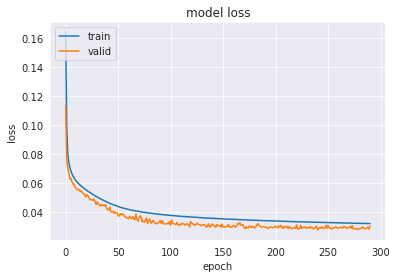

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [80]:
history_list[-1]['loss'][-1]

0.032041557133197784

In [79]:
history_list[-1]['val_loss'][-1]

0.03026246465742588

In [24]:
polynomial_dict_test_list[-1].keys()

dict_keys(['lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'target_polynomials', 'inet_polynomials'])

In [25]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [26]:
poly_optimize

<tf.Tensor: shape=(55,), dtype=float32, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54.], dtype=float32)>

In [27]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [28]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3026)]            0         
_________________________________________________________________
hidden1_512 (Dense)          (None, 512)               1549824   
_________________________________________________________________
dropout1_0.25 (Dropout)      (None, 512)               0         
_________________________________________________________________
hidden2_1024 (Dense)         (None, 1024)              525312    
_________________________________________________________________
output_1024 (Dense)          (None, 55)                56375     
Total params: 2,131,511
Trainable params: 2,131,511
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'model', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 3026), 'dtype':

In [29]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [30]:
scores_test_list[-1]

MAE  RMSE  MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN   NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN   NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN   NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN   NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.055 0.077 0.825   
target_polynomials_VS_lstsq_target_polynomials     0.019 0.024 0.132   
target_polynomials_VS_inet_polynomials             0.230 0.294 1.480   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.051 0.072 0.270   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.212 0.269 0.932   
lstsq_target_polynomials_VS_inet_polynomials       0.229 0.293 2.404   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.526   
target_polynomials_VS_lstsq_target_polynomials         0.816   
target_polynomials_VS_inet_polynomials                 0.134   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.562   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.153   
lstsq_target_polynomials_VS_inet_polynomials           0.133   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    0.000   
target_polynomials_VS_inet_polynomials                            0.000   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.037    0.049    0.157   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.034    0.045    0.142   
lambda_preds_VS_lstsq_target_polynomials             0.036    0.047    0.149   
lambda_preds_VS_inet_polynomials                     0.183    0.217    0.814   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.023    0.029    0.123   
target_polynomials_VS_lstsq_target_polynomials       0.008    0.010    0.046   
target_polynomials_VS_inet_polynomials               0.182    0.218    1.023   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.021    0.027    0.106   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.179    0.214    0.911   
lstsq_target_polynomials_VS_inet_polynomials         0.181    0.217    0.725   

                                                    R2 FV  RAAE FV  RMAE FV  \
lambda_preds_VS_target_polynomials                  0.997    0.040    0.261   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.998    0.037    0.221   
lambda_preds_VS_lstsq_target_polynomials            0.997    0.039    0.255   
lambda_preds_VS_inet_polynomials                    0.938    0.194    0.545   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.999    0.025    0.118   
target_polynomials_VS_lstsq_target_polynomials      1.000    0.009    0.040   
target_polynomials_VS_inet_polynomials              0.938    0.192    0.640   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.999    0.023    0.110   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.939    0.191    0.617   
lstsq_target_polynomials_VS_inet_polynomials        0.939 

In [31]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.041 0.035 0.035 0.042   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.039 0.032 0.033 0.036   
lambda_preds_VS_lstsq_target_polynomials           0.040 0.034 0.034 0.041   
lambda_preds_VS_inet_polynomials                   0.179 0.198 0.144 0.108   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.022 0.026 0.021 0.025   
target_polynomials_VS_lstsq_target_polynomials     0.009 0.007 0.008 0.009   
target_polynomials_VS_inet_polynomials             0.171 0.207 0.141 0.104   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.022 0.024 0.019 0.025   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.174 0.198 0.140 0.099   
lstsq_target_polynomials_VS_inet_polynomials       0.172 0.207 0.139 0.104   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.037 0.036 0.034 0.035   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.032 0.033 0.032 0.033   
lambda_preds_VS_lstsq_target_polynomials           0.036 0.035 0.033 0.034   
lambda_preds_VS_inet_polynomials                   0.340 0.198 0.221 0.116   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.025 0.022 0.020 0.024   
target_polynomials_VS_lstsq_target_polynomials     0.007 0.009 0.008 0.008   
target_polynomials_VS_inet_polynomials             0.335 0.200 0.229 0.114   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.023 0.021 0.018 0.023   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.343 0.200 0.218 0.109   
lstsq_target_polynomials_VS_inet_polynomials       0.334 0.198 0.229 0.114   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.035 0.036 0.036 0.035   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.031 0.034 0.032 0.033   
lambda_preds_VS_lstsq_target_polynomials           0.033 0.034 0.035 0.033   
lambda_preds_VS_inet_polynomials                   0.112 0.369 0.112 0.132   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.022 0.020 0.023 0.017   
target_polynomials_VS_lstsq_target_polynomials     0.008 0.008 0.007 0.009   
target_polynomials_VS_inet_polynomials             0.101 0.375 0.106 0.125   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.019 0.018 0.022 0.015   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.109 0.366 0.106 0.126   
lstsq_target_polynomials_VS_inet_polynomials       0.101 0.375 0.107 0.123   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.037 0.034 0.042 0.039   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.033 0.033 0.040 0.039   
lambda_preds_VS_lstsq_target_polynomials           0.037 0.033 0.041 0.038   
lambda_preds_VS_inet_polynomials                   0.138 0.148 0.154 0.244   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.023 0.019 0.023 0.022   
target_polynomials_VS_lstsq_target_polynomials     0.009 0.008 0.009 0.010   
target_polynomials_VS_inet_polynomials             0.144 0.147 0.148 0.247   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.022 0.017 0.023 0.022   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.138 0.144 0.146 0.246   
lstsq_target_polynomials_VS_inet_polynomials       0.146 0.145 0.149 0.244   

                                                    L-16  L-17  L-18  L-19  
lambda_preds_VS_target_polynomials                 0.040 0.033 0.037 0.040  
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.035 0.032 0.034 0.038  
lambda_preds_VS_lstsq_target_polynomials           0.040 0.032 0.036 0.039  
lambda_preds_VS_inet_polynomials                   0.314 0.120 0.117 0.186  
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.028 0.019 0.022 0.027  
target_polynomials_VS_lstsq_target_polynomials     0.008 0.007 0.008 0.009  
target_polynomials_VS_inet_polynomials             0.310 0.120 0.116 0.196  
l

In [32]:
distrib_dict_test_list[-1]['R2']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.996 0.998 0.996 0.993   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997 0.999 0.996 0.995   
lambda_preds_VS_lstsq_target_polynomials           0.996 0.998 0.996 0.994   
lambda_preds_VS_inet_polynomials                   0.937 0.960 0.939 0.963   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.998 0.998   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.941 0.957 0.938 0.966   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 0.998   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.938 0.961 0.940 0.967   
lstsq_target_polynomials_VS_inet_polynomials       0.942 0.957 0.940 0.967   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.996 0.995 0.999 0.997   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997 0.996 0.999 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.996 0.995 0.999 0.998   
lambda_preds_VS_inet_polynomials                   0.744 0.880 0.959 0.973   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.998 0.998 1.000 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.750 0.880 0.957 0.973   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.998 0.998 1.000 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.743 0.882 0.960 0.975   
lstsq_target_polynomials_VS_inet_polynomials       0.751 0.882 0.957 0.973   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.997 0.998 0.997 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997 0.998 0.997 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.998 0.997 0.998   
lambda_preds_VS_inet_polynomials                   0.968 0.818 0.968 0.976   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 1.000   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.972 0.815 0.970 0.978   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 1.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.970 0.822 0.970 0.977   
lstsq_target_polynomials_VS_inet_polynomials       0.973 0.815 0.969 0.978   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.997 0.998 0.996 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.997 0.998 0.997 0.999   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.998 0.996 0.999   
lambda_preds_VS_inet_polynomials                   0.963 0.966 0.956 0.954   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 1.000   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.962 0.965 0.954 0.954   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 1.000 0.999 1.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.965 0.966 0.956 0.955   
lstsq_target_polynomials_VS_inet_polynomials       0.961 0.966 0.954 0.955   

                                                    L-16  L-17  L-18  L-19  
lambda_preds_VS_target_polynomials                 0.998 0.998 0.997 0.998  
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.999 0.998 0.999  
lambda_preds_VS_lstsq_target_polynomials           0.998 0.998 0.997 0.998  
lambda_preds_VS_inet_polynomials                   0.911 0.979 0.975 0.969  
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 0.999  
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000  
target_polynomials_VS_inet_polynomials             0.913 0.978 0.975 0.966  
l

In [33]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9954424035081916


-0.454795082405812*a**2 + 0.0062414968820481*a*b + 0.0817998250364602*a*c + 0.545385051392736*a*d - 0.43442455214304*a*e + 0.024633861516097*a*f - 0.898863822741239*a*g + 0.245182420383176*a*h - 0.0668284060251732*a*i - 0.453152256710118*a + 0.0229090769828634*b**2 + 0.158290476858964*b*c - 0.276136599338734*b*d - 0.409540536429244*b*e - 0.891195307091884*b*f + 0.181178187040308*b*g - 0.923330571298552*b*h - 0.154023910505926*b*i + 0.473577411140809*b - 0.82275026369784*c**2 + 0.885432707684998*c*d - 0.392337508388838*c*e + 0.607782303966997*c*f - 0.0793811654311481*c*g - 0.479397371471972*c*h + 0.702937596035239*c*i - 0.813940739222766*c - 0.0251942417521634*d**2 + 0.794148645352203*d*e + 0.699861285748914*d*f - 0.880718101123667*d*g - 0.818602442785571*d*h - 0.622670466930648*d*i + 0.334635290049842*d + 0.32791313316679*e**2 - 0.0803837992232104*e*f - 0.816058355923231*e*g + 0.972851036765912*e*h - 0.0274417256068091*e*i - 0.424928397001896*e + 0.643883353464844*f**2 + 0.123219798007

In [34]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.9379120606566719 (20 Samples)
Mean (only positive): 0.9379120606566719 (20 Samples)


In [35]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9975785068276568 (20 Samples)
Mean (only positive): 0.9975785068276568 (20 Samples)


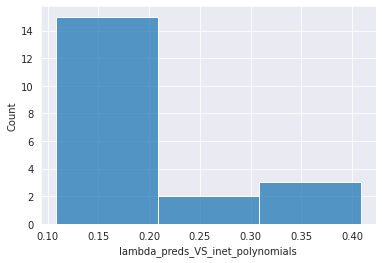

In [36]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

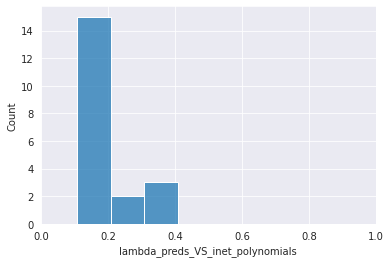

In [37]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


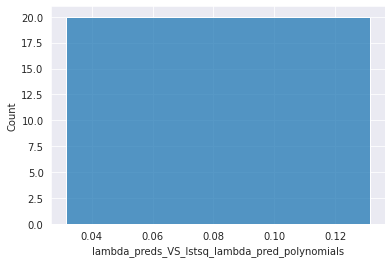

In [38]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

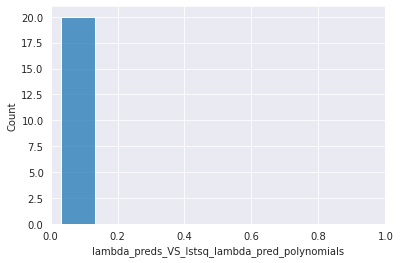

In [39]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


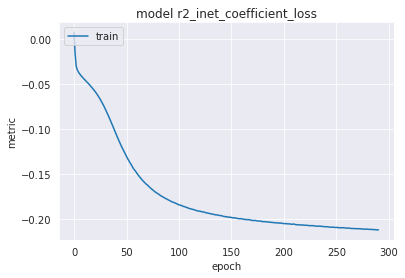

In [40]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


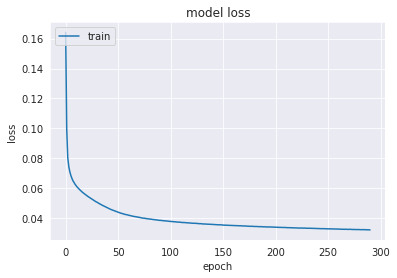

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [42]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [43]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [44]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [45]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.1898*a**2 - 0.2057*a*b + 0.6828*a*c - 0.2341*a*d - 0.1028*a*e - 0.7039*a*f - 0.176*a*g - 0.2431*a*h - 0.6231*a*i - 0.0081*a + 0.6341*b**2 + 0.7881*b*c + 0.7433*b*d + 0.4193*b*e + 0.8473*b*f + 0.7891*b*g + 0.5768*b*h - 0.1427*b*i + 0.0471*b - 0.0388*c**2 + 0.8329*c*d - 0.0474*c*e + 0.864*c*f + 0.0856*c*g - 0.3877*c*h + 0.0828*c*i + 1.1429*c - 0.4551*d**2 + 0.5492*d*e - 0.6328*d*f - 0.9364*d*g + 0.8458*d*h - 0.9892*d*i + 0.3656*d + 0.2987*e**2 + 0.6114*e*f - 0.4581*e*g + 0.3045*e*h + 0.3707*e*i - 0.9207*e + 0.0022*f**2 + 0.3368*f*g - 0.4193*f*h - 0.5772*f*i + 0.0216*f - 0.5169*g**2 + 0.8991*g*h - 0.7337*g*i - 1.1307*g + 0.1729*h**2 - 0.3908*h*i - 0.2033*h + 0.6163*i**2 - 0.5676*i - 1.0403

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.2088*a**2 - 0.1833*a*b + 0.7108*a*c - 0.219*a*d - 0.1219*a*e - 0.7037*a*f - 0.1933*a*g - 0.2261*a*h - 0.6702*a*i - 0.0282*a + 0.6832*b**2 + 0.8143*b*c + 0.7983*b*d + 0.4195*b*e + 0.8938*b*f + 0.7897*b*g + 0.5923*b*h - 0.1465*b*i - 0.0905*b + 0.0211*c**2 + 0.9127*c*d - 0.0448*c*e + 0.9389*c*f + 0.0657*c*g - 0.433*c*h + 0.1232*c*i + 0.9873*c - 0.495*d**2 + 0.5433*d*e - 0.6231*d*f - 1.0031*d*g + 0.8407*d*h - 1.0176*d*i + 0.4059*d + 0.3102*e**2 + 0.6281*e*f - 0.4692*e*g + 0.3199*e*h + 0.3614*e*i - 0.9469*e + 0.0263*f**2 + 0.3253*f*g - 0.4056*f*h - 0.6201*f*i - 0.0649*f - 0.5684*g**2 + 0.8648*g*h - 0.8089*g*i - 0.9827*g + 0.2074*h**2 - 0.4123*h*i - 0.2028*h + 0.6725*i**2 - 0.5109*i - 0.9978

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.2301*a**2 - 0.1897*a*b + 0.7283*a*c - 0.2189*a*d - 0.1376*a*e - 0.708*a*f - 0.1805*a*g - 0.234*a*h - 0.6943*a*i - 0.0386*a + 0.7005*b**2 + 0.8451*b*c + 0.809*b*d + 0.4118*b*e + 0.9329*b*f + 0.8076*b*g + 0.5856*b*h - 0.1282*b*i - 0.1539*b + 0.0542*c**2 + 0.9142*c*d - 0.0707*c*e + 0.9578*c*f + 0.0576*c*g - 0.4388*c*h + 0.1182*c*i + 0.931*c - 0.5123*d**2 + 0.5729*d*e - 0.6323*d*f - 0.9872*d*g + 0.8317*d*h - 0.9965*d*i + 0.3901*d + 0.3263*e**2 + 0.6496*e*f - 0.4741*e*g + 0.3*e*h + 0.3728*e*i - 0.9558*e + 0.036*f**2 + 0.3053*f*g - 0.3977*f*h - 0.6228*f*i - 0.1066*f - 0.5758*g**2 + 0.8732*g*h - 0.7998*g*i - 0.9866*g + 0.1865*h**2 - 0.3987*h*i - 0.1631*h + 0.6919*i**2 - 0.5639*i - 0.9449

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


0.0768999978899956*a**2 - 0.328399986028671*a*b + 0.999199986457825*a*c - 0.258199989795685*a*d - 0.388799995183945*a*e - 0.486600011587143*a*f - 0.164000004529953*a*g - 0.23989999294281*a*h - 0.558799982070923*a*i + 0.0359000004827976*a + 0.30349999666214*b**2 + 0.869799971580505*b*c + 0.323399990797043*b*d + 0.516099989414215*b*e + 0.832899987697601*b*f + 0.453399986028671*b*g + 0.376199990510941*b*h + 0.239700004458427*b*i + 0.509999990463257*b + 0.220899999141693*c**2 + 0.580099999904633*c*d - 0.361600011587143*c*e + 0.796599984169006*c*f - 0.241999998688698*c*g - 0.231900006532669*c*h - 0.131099998950958*c*i + 1.09099996089935*c - 0.313199996948242*d**2 + 0.685599982738495*d*e - 0.524600028991699*d*f - 0.690599977970123*d*g + 0.95389997959137*d*h - 0.482499986886978*d*i - 0.0195000004023314*d - 0.0766000002622604*e**2 + 0.575100004673004*e*f - 0.412299990653992*e*g + 0.17849999666214*e*h + 0.0299999993294477*e*i - 0.248199999332428*e + 0.0300999991595745*f**2 + 0.234300002455711*f

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


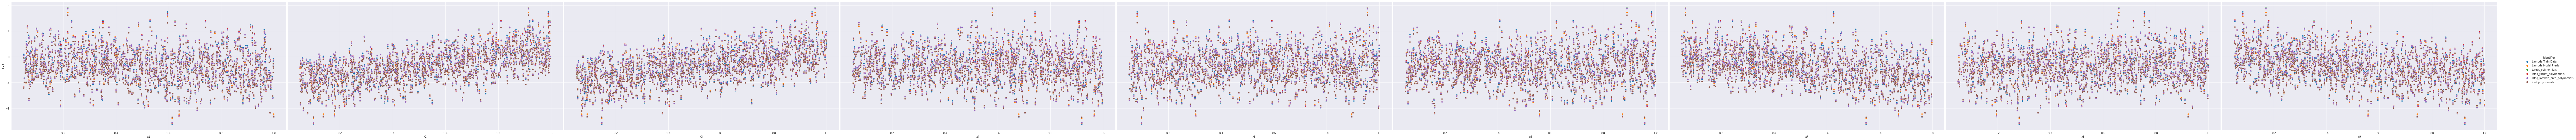

In [46]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

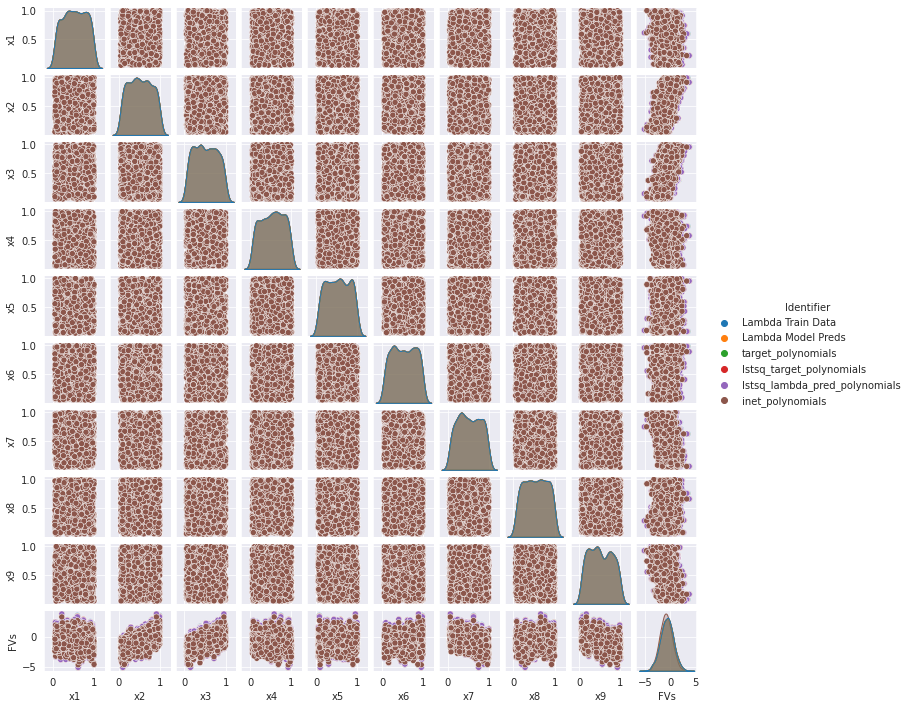

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

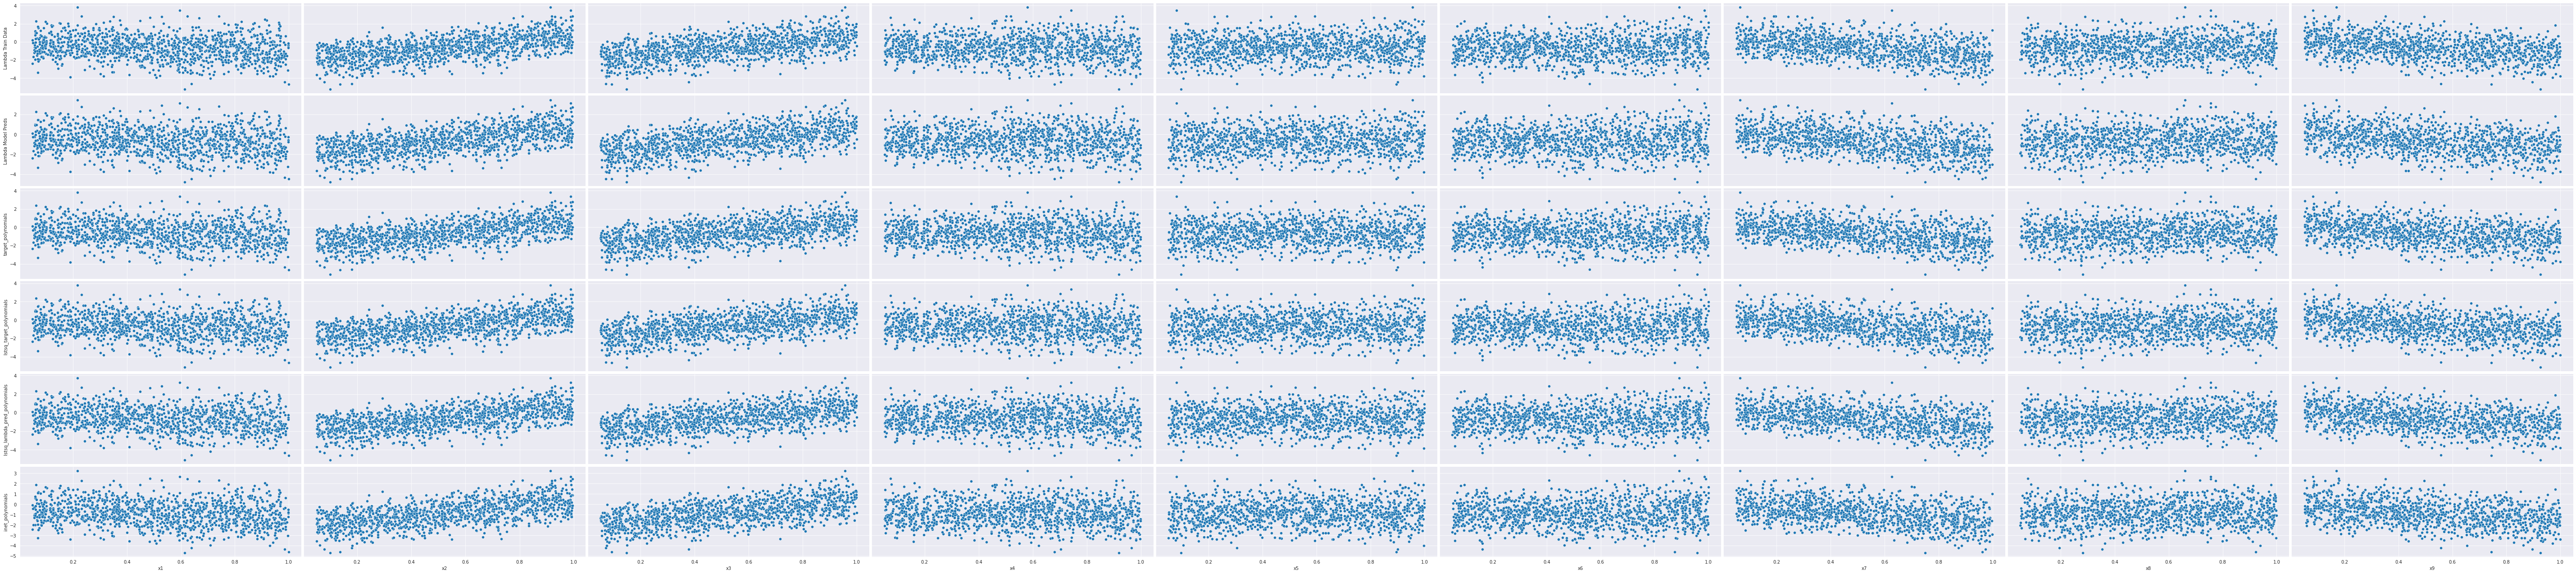

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [49]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [50]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  2.3min finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  2.3min finished


In [51]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 4.8818


In [52]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 13.9644


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [53]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:  2.3min finished


In [54]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 1.3199


In [55]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [56]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 0.6988788843154907 
 Curr_res: 1.5581401586532593 
 Iteration 1, Step 21
Optimization terminated at 0.3749291002750397


array([ 0.06217318, -0.30947757, -0.44764876,  0.35796133,  0.00199334,
       -0.2602653 , -0.21666354, -0.63734835, -0.5986541 , -0.07986416,
        0.15330002, -0.62623304,  0.34109363, -0.17059916, -0.3089245 ,
        0.11907394, -0.16706586, -0.12534472, -0.31351325, -0.44510078,
       -0.6501063 , -0.49512076, -0.23397297, -0.02051152, -0.38514438,
        0.22326458, -0.3958465 ,  0.12237804,  0.19013321, -0.6601059 ,
       -0.26580358, -0.50455385, -0.04220929,  0.05310293,  0.25305805,
       -0.38678193,  0.07553487,  0.03238217, -0.18691161,  0.03039376,
       -0.14678107,  0.27173325,  0.22744438,  0.46079293, -0.36494556,
       -0.31624603, -0.24026914,  0.7368216 ,  0.3056764 , -0.26774248,
       -0.00097744, -0.2703144 ,  0.49475995,  0.52980065,  0.05973337],
      dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [57]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
0      1.000         0.618       0.457   0.536         0.238       0.000   
1      1.000         0.729       0.647   0.590         0.208       0.000   
2      1.000         0.646       0.565   0.517         0.179       0.000   
3      1.000         0.610       0.565   0.516         0.238       0.000   
4      1.000         0.605       0.511   0.521         0.149       0.000   

   Europe  Japan   USA  
0   0.000  0.000 1.000  
1   0.000  0.000 1.000  
2   0.000  0.000 1.000  
3   0.000  0.000 1.000  
4   0.000  0.000 1.000

In [58]:
#%load_ext autoreload

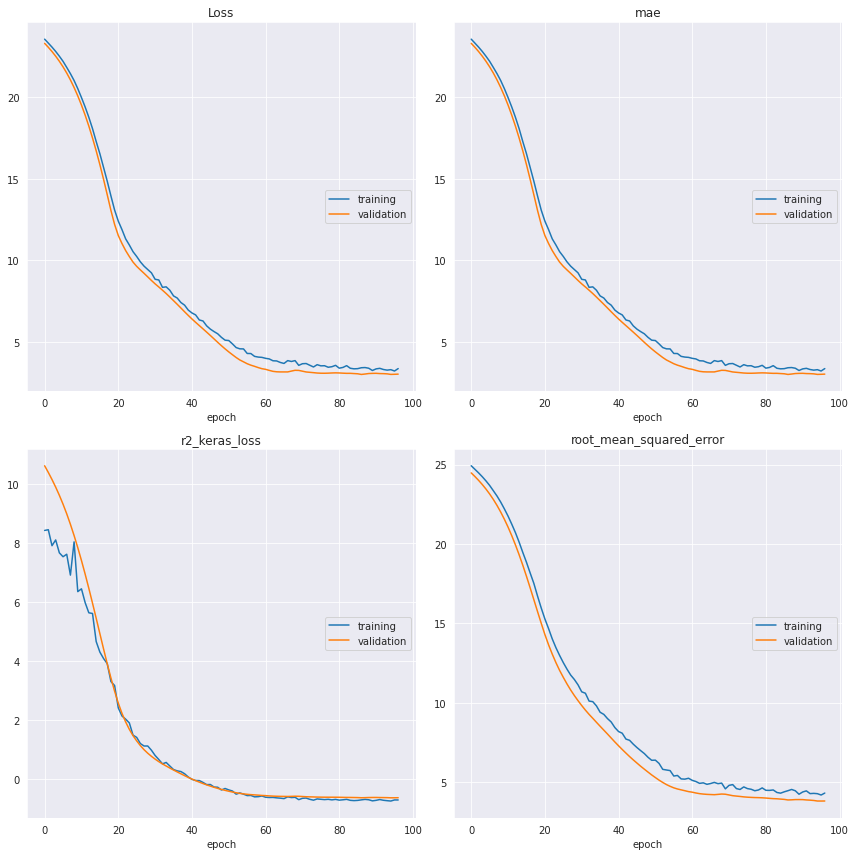

Loss
	training         	 (min:    3.218, max:   23.561, cur:    3.368)
	validation       	 (min:    3.008, max:   23.306, cur:    3.027)
mae
	training         	 (min:    3.218, max:   23.561, cur:    3.368)
	validation       	 (min:    3.008, max:   23.306, cur:    3.027)
r2_keras_loss
	training         	 (min:   -0.739, max:    8.463, cur:   -0.702)
	validation       	 (min:   -0.629, max:   10.632, cur:   -0.626)
root_mean_squared_error
	training         	 (min:    4.182, max:   24.931, cur:    4.306)
	validation       	 (min:    3.803, max:   24.481, cur:    3.805)


In [59]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [60]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [61]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [62]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQt Poly:


25.2286539480068*a**2 + 34.0287139550307*a*b + 18.0932570499931*a*c + 25.6485669178858*a*d + 11.8356985637181*a*e + 28.4174665068772*a*f + 22.312311477323*a*g + 31.2097232156447*a*h + 15.2985191803865*a*i + 10.4762538668444*a + 14.8978754312047*b**2 + 26.3572224222291*b*c + 34.2483464499565*b*d + 27.2326405851262*b*e + 13.5408922912164*b*f + 10.3428910762516*b*g + 14.5209934753284*b*h + 20.422211908195*b*i + 15.954733133596*b + 35.6469998184674*c**2 + 12.0777219588615*c*d + 35.1331433092717*c*e + 21.0078435055443*c*f + 23.0491621639872*c*g + 15.4149978936722*c*h + 26.3612584739928*c*i + 30.0733921149539*c + 15.6029296372462*d**2 + 26.7506871749194*d*e + 26.006074979453*d*f + 27.5268291110638*d*g + 11.135540926069*d*h + 34.6302369713652*d*i + 40.1212238582529*d + 15.5541409493661*e**2 + 31.5773655681719*e*f + 24.7182947609047*e*g + 34.5726896812036*e*h + 19.4181911667596*e*i + 30.2665247147964*e + 27.9886524802845*f**2 + 29.0009753281196*f*g + 19.4200131051318*f*h + 27.4544430490185*f*i

MAE Model:  0.15916017529428483
MAE Data:  3.250696253893852
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [63]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


2.96492028236389*a**2 - 0.0957509428262711*a*b - 0.39792212843895*a*c + 0.0285222474485636*a*d - 2.06133580207825*a*e - 0.696584403514862*a*f - 0.311909765005112*a*g - 0.671457946300507*a*h + 0.137601211667061*a*i - 2.03490877151489*a + 0.936993956565857*b**2 - 0.448092490434647*b*c - 0.675355315208435*b*d - 0.422802418470383*b*e + 1.35542404651642*b*f - 1.09763860702515*b*g - 1.20522463321686*b*h - 0.718073785305023*b*i + 0.203426823019981*b + 1.96194791793823*c**2 - 0.0498489066958427*c*d + 0.393106937408447*c*e - 0.00121343904174864*c*f + 1.13653588294983*c*g - 0.249414637684822*c*h - 0.0789629966020584*c*i + 0.228018373250961*c + 1.88094508647919*d**2 + 0.171559557318687*d*e + 1.89424824714661*d*f - 1.71343600749969*d*g + 0.508641600608826*d*h + 1.31688106060028*d*i - 1.30596816539764*d + 0.316205620765686*e**2 + 0.307039558887482*e*f - 0.700885832309723*e*g - 0.98771721124649*e*h - 0.638217449188232*e*i - 0.625207185745239*e + 1.20625936985016*f**2 - 0.670695543289185*f*g - 1.3450

MAE Model:  9.700305482282022
MAE Data:  8.78134391164733
Computation Time: 0:00:00
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [64]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


Current best: 0.6496659517288208 
 Curr_res: 0.6524602174758911 
 Iteration 2, Step 450
Optimization terminated at 0.6091649532318115
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-0.461753368377686*a**2 - 1.89270520210266*a*b - 1.9220107793808*a*c - 2.36398649215698*a*d - 0.686269402503967*a*e - 0.805770456790924*a*f - 0.480718672275543*a*g + 0.0308452863246202*a*h - 1.5617800951004*a*i + 3.93710374832153*a - 1.11875867843628*b**2 - 1.69425702095032*b*c - 2.00124382972717*b*d - 0.781262993812561*b*e - 1.0262907743454*b*f - 0.846341907978058*b*g - 0.775681138038635*b*h - 1.27628362178802*b*i + 3.55218505859375*b - 0.868202865123749*c**2 - 1.90501773357391*c*d - 0.619940400123596*c*e - 0.721471667289734*c*f - 0.646418035030365*c*g - 0.472360849380493*c*h - 1.64161264896393*c*i + 4.45387554168701*c - 0.691526114940643*d**2 - 0.928329229354858*d*e - 0.694056749343872*d*f - 0.745304226875305*d*g - 0.688530802726746*d*h - 1.65770447254181*d*i + 3.26282739639282*d + 2.72592949867249*e**2 + 1.66887557506561*e*f + 1.67281889915466*e*g + 1.98716986179352*e*h + 0.773875594139099*e*i + 6.01716613769531*e + 2.90022349357605*f**2 + 2.07680535316467*f*g + 2.09302687644958*f*h

MAE Model:  1.4938927138076943
MAE Data:  3.3586613270163057
Computation Time: 0:02:39
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [65]:
#%load_ext autoreload

In [66]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.26          75376.8       31          17.1493           16.679      3.93m
   1    10.77          30.8964       19          7.64499          7.60779      2.55m
   2    16.44          28.6539        7          5.63116          5.67009      2.68m
   3    22.61          26.2427       11          3.77382          3.54974      2.75m
   4    24.38          26.1236       27          3.66047          4.11925      2.68m
   5    24.27          28.3932       37          3.16534          3.10417      2.55m
   6    25.07          26.2236       37          2.96932          3.23797      2.50m
   7    25.94          28.6484       47          2.74389          2.61233      2.21m
   8    25.88           37.037       43          2.15818           2.5221  

-2.572*X1 - X2 - 1.8758389261745*X3 + 10.0671140939597*X4 + 11.2607540200892*X5 + 9.71140939597315*X6 + 11.0671140939597*X7 + 4.35570469798658*X8 + 8.16152249898653

MAE Model:  0.8519412532146543
MAE Data:  3.3930433767223254
Computation Time: 0:04:03
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [67]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

---- Tuning the basis functions ----


  0%|          | 0/9 [00:00<?, ?it/s]

----  Optimizing the metamodel  ----


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Metamodel Function:


1/(0.220096844127837*exp(-0.186721113522898*X0**2*X1**2 - 0.135257915646318*X0**2*X2**2 - 0.247831034740409*X0**2*X3**2 - 0.0429184637600559*X0**2*X4**2 + 0.122171873850546*X0**2*X5**2 - 0.111598302759871*X0**2*X6**2 + 0.0174196632779028*X0**2*X7**2 - 0.214951313449075*X0**2*X8**2 + 1.53382278307619*X0**2 + 1.78835815904025*X0*X1 + 1.23277926852691*X0*X2 + 2.10132839927241*X0*X3 + 0.499800501481204*X0*X4 - 1.38402648410247*X0*X5 + 1.31983375228957*X0*X6 - 0.193217011730341*X0*X7 + 2.23807013217128*X0*X8 - 0.438834516155076*X0 - 0.255444817023303*X1**2*X2**2 - 0.30639767260681*X1**2*X3**2 - 0.0153275585085175*X1**2*X4**2 - 0.083070291458762*X1**2*X5**2 - 0.10106590331847*X1**2*X6**2 + 0.0597824863194701*X1**2*X7**2 - 0.126679634032459*X1**2*X8**2 + 1.82450661669192*X1**2 + 2.46012182740256*X1*X2 + 2.89280747554609*X1*X3 + 0.178398894855991*X1*X4 + 0.918892741654333*X1*X5 + 1.15097079703496*X1*X6 - 0.681525437165116*X1*X7 + 1.30426129580641*X1*X8 - 3.53764193837161*X1 - 0.238651555324023

MAE Model:  22.233490306034284
MAE Data:  21.710765432355263
Computation Time: 0:01:36
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [68]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [69]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interpretation Net Poly:


2.96492028236389*a**2 - 0.0957509428262711*a*b - 0.39792212843895*a*c + 0.0285222474485636*a*d - 2.06133580207825*a*e - 0.696584403514862*a*f - 0.311909765005112*a*g - 0.671457946300507*a*h + 0.137601211667061*a*i - 2.03490877151489*a + 0.936993956565857*b**2 - 0.448092490434647*b*c - 0.675355315208435*b*d - 0.422802418470383*b*e + 1.35542404651642*b*f - 1.09763860702515*b*g - 1.20522463321686*b*h - 0.718073785305023*b*i + 0.203426823019981*b + 1.96194791793823*c**2 - 0.0498489066958427*c*d + 0.393106937408447*c*e - 0.00121343904174864*c*f + 1.13653588294983*c*g - 0.249414637684822*c*h - 0.0789629966020584*c*i + 0.228018373250961*c + 1.88094508647919*d**2 + 0.171559557318687*d*e + 1.89424824714661*d*f - 1.71343600749969*d*g + 0.508641600608826*d*h + 1.31688106060028*d*i - 1.30596816539764*d + 0.316205620765686*e**2 + 0.307039558887482*e*f - 0.700885832309723*e*g - 0.98771721124649*e*h - 0.638217449188232*e*i - 0.625207185745239*e + 1.20625936985016*f**2 - 0.670695543289185*f*g - 1.3450

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Network Poly:


-0.461753368377686*a**2 - 1.89270520210266*a*b - 1.9220107793808*a*c - 2.36398649215698*a*d - 0.686269402503967*a*e - 0.805770456790924*a*f - 0.480718672275543*a*g + 0.0308452863246202*a*h - 1.5617800951004*a*i + 3.93710374832153*a - 1.11875867843628*b**2 - 1.69425702095032*b*c - 2.00124382972717*b*d - 0.781262993812561*b*e - 1.0262907743454*b*f - 0.846341907978058*b*g - 0.775681138038635*b*h - 1.27628362178802*b*i + 3.55218505859375*b - 0.868202865123749*c**2 - 1.90501773357391*c*d - 0.619940400123596*c*e - 0.721471667289734*c*f - 0.646418035030365*c*g - 0.472360849380493*c*h - 1.64161264896393*c*i + 4.45387554168701*c - 0.691526114940643*d**2 - 0.928329229354858*d*e - 0.694056749343872*d*f - 0.745304226875305*d*g - 0.688530802726746*d*h - 1.65770447254181*d*i + 3.26282739639282*d + 2.72592949867249*e**2 + 1.66887557506561*e*f + 1.67281889915466*e*g + 1.98716986179352*e*h + 0.773875594139099*e*i + 6.01716613769531*e + 2.90022349357605*f**2 + 2.07680535316467*f*g + 2.09302687644958*f*h

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LSTSQ Poly:


-0.0101610841826315*a**2 + 0.0610718578665193*a*b + 0.0392276594457492*a*c + 0.0495285069394801*a*d - 0.0691341730412754*a*e - 0.0798658987280924*a*f - 0.00938757226654796*a*g - 0.0292498400796044*a*h - 0.0358372611208055*a*i - 1.62547338028931*a + 0.0470167612481587*b**2 + 0.0172055565186422*b*c + 0.101784714898919*b*d - 0.0947672393339908*b*e - 0.0831109232225001*b*f - 0.0720460651097261*b*g - 0.0528087416280731*b*h - 0.0317607564587626*b*i - 2.91017881067807*b + 0.0363924697509526*c**2 + 0.0607934382175406*c*d - 0.0553290870436242*c*e - 0.093828214075813*c*f - 0.0524776583394473*c*g - 0.0231551835834485*c*h - 0.00552175302961389*c*i - 1.52406140289448*c + 0.0819524024647262*d**2 - 0.103311683253685*d*e - 0.113378801671597*d*f - 0.0803490201314929*d*g - 0.0586461907568427*d*h - 0.0270910112731908*d*i - 3.24548728512967*d + 0.0588527690117862*e**2 + 0.0998024766036924*e*f + 0.101213800906104*e*g + 0.0565247630717884*e*h + 0.0340528404472021*e*i + 10.1508605136043*e + 0.076090446649592

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Symbolic Regression Function:


-2.572*X1 - X2 - 1.8758389261745*X3 + 10.0671140939597*X4 + 11.2607540200892*X5 + 9.71140939597315*X6 + 11.0671140939597*X7 + 4.35570469798658*X8 + 8.16152249898653

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Metamodel Function:


1/(0.220096844127837*exp(-0.186721113522898*X0**2*X1**2 - 0.135257915646318*X0**2*X2**2 - 0.247831034740409*X0**2*X3**2 - 0.0429184637600559*X0**2*X4**2 + 0.122171873850546*X0**2*X5**2 - 0.111598302759871*X0**2*X6**2 + 0.0174196632779028*X0**2*X7**2 - 0.214951313449075*X0**2*X8**2 + 1.53382278307619*X0**2 + 1.78835815904025*X0*X1 + 1.23277926852691*X0*X2 + 2.10132839927241*X0*X3 + 0.499800501481204*X0*X4 - 1.38402648410247*X0*X5 + 1.31983375228957*X0*X6 - 0.193217011730341*X0*X7 + 2.23807013217128*X0*X8 - 0.438834516155076*X0 - 0.255444817023303*X1**2*X2**2 - 0.30639767260681*X1**2*X3**2 - 0.0153275585085175*X1**2*X4**2 - 0.083070291458762*X1**2*X5**2 - 0.10106590331847*X1**2*X6**2 + 0.0597824863194701*X1**2*X7**2 - 0.126679634032459*X1**2*X8**2 + 1.82450661669192*X1**2 + 2.46012182740256*X1*X2 + 2.89280747554609*X1*X3 + 0.178398894855991*X1*X4 + 0.918892741654333*X1*X5 + 1.15097079703496*X1*X6 - 0.681525437165116*X1*X7 + 1.30426129580641*X1*X8 - 3.53764193837161*X1 - 0.238651555324023

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [70]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [71]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [72]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_91 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
[array([[ 1.0167775 , -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
      dtype=float32), array([-0.16888502,  0.        ,  0.        ,  0.        ,  0.        ],
      dtype=float32), array([[ 1.562712  , -0.02688342, -0.01456122],
       [-0.42922467,  0.40037042,  0.67994815],
       [ 0.77379066,  0.4318593 , -0.26109576],
       [ 0.08172262, -0.41291407,  0.3418085 ],
  

In [73]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_94 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
[array([[13.799208  , -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
      dtype=float32), array([0.0819062, 0.       , 0.       , 0.       , 0.       ],
      dtype=float32), array([[14.5386095 , -0.02688342, -0.01456132],
       [-0.42922467,  0.40037042,  0.67994815],
       [ 0.77379066,  0.4318593 , -0.26109576],
       [ 0.08172262, -0.41291407,  0.3418085 ],
       [-0.6

In [74]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_97 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 4         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.11970227, -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
      dtype=float32), array([31.566597,  0.      ,  0.      ,  0.      ,  0.      ],
      dtype=float32), array([[ 4.3192453 , -0.02688342, -0.01456229],
       [-0.42922467,  0.40037042,  0.67994815],
       [ 0.77379066,  0.4318593 , -0.26109576],
       [ 0.08172262, -0.41291407,  0.3418085 ],
       [-0.6

In [75]:
model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

NameError: name 'model_2' is not defined

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()